<a href="https://colab.research.google.com/github/tensorspace/appstore_analysis/blob/main/appstore_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('appstore_analysis').getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [3]:
google_df=spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Google-Playstore.csv", sep=',', header=True)

In [ ]:
google_df.show()

+----------------------------------+--------------------+-----------------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+--------------------+--------------------+--------------------+------------+------------+--------------+--------------------+------------+----------------+--------------+-------------------+
|                          App Name|              App Id|         Category|Rating|Rating Count|Installs|Minimum Installs|Maximum Installs|Free|Price|Currency|Size|Minimum Android|        Developer Id|   Developer Website|     Developer Email|    Released|Last Updated|Content Rating|      Privacy Policy|Ad Supported|In App Purchases|Editors Choice|       Scraped Time|
+----------------------------------+--------------------+-----------------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+--------------------+--------------------+--------------------+------------+-----

In [4]:
apple_df=spark.read.csv("/content/drive/MyDrive/Colab Notebooks/appleAppData.csv", sep=',', header=True)

In [ ]:
apple_df.show()

+--------------------+--------------------+--------------------+----------------+--------------+----------+--------------------+--------------------+--------------------+-------+-----+--------+-----+-----------+--------------------+--------------------+--------------------+-------------------+-------+---------------------+-----------------------+
|              App_Id|            App_Name|        AppStore_Url|   Primary_Genre|Content_Rating|Size_Bytes|Required_IOS_Version|            Released|             Updated|Version|Price|Currency| Free|DeveloperId|           Developer|       Developer_Url|   Developer_Website|Average_User_Rating|Reviews|Current_Version_Score|Current_Version_Reviews|
+--------------------+--------------------+--------------------+----------------+--------------+----------+--------------------+--------------------+--------------------+-------+-----+--------+-----+-----------+--------------------+--------------------+--------------------+-------------------+-------+

In [5]:
goole_game_genres=["Action", "Adventure", "Arcade", "Board", "Card", "Casino", "Casual", "Educational", "Music", "Puzzle", "Racing", "Role", "Playing", "Simulation", "Sports", " Strategy", "Trivia", "Word"]
selected_google_df=google_df.filter(col("Category").isin(goole_game_genres+["Music & Audio"]+["Health & Fitness"])) \
.withColumn("Category", when(col("Category").isin(goole_game_genres), "Game")
            .when(col("Category")=="Music & Audio", "Music")
            .otherwise("Health")) \
.withColumn("Size", when(col("Size").substr(-1, 1)=="M", expr("substring(Size, 1, length(Size)-1)").cast("double"))
            .when(col("Size").substr(-1, 1)=="G", expr("substring(Size, 1, length(Size)-1)").cast("double")*1024)
            .when(col("Size").substr(-1, 1)=="k", expr("substring(Size, 1, length(Size)-1)").cast("double")/1024)
            .otherwise(None)) \
.withColumn("Released", when(length(col("Released"))==11, concat(col("Released").substr(1, 4), lit("0"), col("Released").substr(5, 7)))
            .otherwise(col("Released"))) \
.withColumn("Release_Month", to_date(col("Released"), "MMM dd, yyyy").substr(1, 7)) \
.withColumn("Release_Year", to_date(col("Released"), "MMM dd, yyyy").substr(1, 4)) \
.cache()

In [ ]:
selected_google_df.show()

+--------------------+--------------------+--------+------+------------+--------+----------------+----------------+----+-----+--------+-----+---------------+--------------------+--------------------+--------------------+------------+------------+--------------+--------------------+------------+----------------+--------------+-------------------+-------------+------------+
|            App Name|              App Id|Category|Rating|Rating Count|Installs|Minimum Installs|Maximum Installs|Free|Price|Currency| Size|Minimum Android|        Developer Id|   Developer Website|     Developer Email|    Released|Last Updated|Content Rating|      Privacy Policy|Ad Supported|In App Purchases|Editors Choice|       Scraped Time|Release_Month|Release_Year|
+--------------------+--------------------+--------+------+------------+--------+----------------+----------------+----+-----+--------+-----+---------------+--------------------+--------------------+--------------------+------------+------------+----

In [6]:
apple_genres=["Games", "Music", "Health & Fitness"]
selected_apple_df=apple_df.filter(col("Primary_Genre").isin(apple_genres)) \
.withColumn("Primary_Genre", when(col("Primary_Genre")=="Health & Fitness", "Health")
            .when(col("Primary_Genre")=="Games", "Game")
            .otherwise(col("Primary_Genre"))) \
.withColumn("Size_Bytes", col("Size_Bytes").cast("int")/1048576) \
.withColumn("Release_Month", col("Released").substr(1, 7)) \
.withColumn("Release_Year", col("Released").substr(1, 4)) \
.cache()

In [ ]:
selected_apple_df.show()

+--------------------+--------------------+--------------------+-------------+--------------+--------------+--------------------+--------------------+--------------------+-------+-----+--------+-----+-----------+--------------------+--------------------+--------------------+-------------------+-------+---------------------+-----------------------+-------------+------------+
|              App_Id|            App_Name|        AppStore_Url|Primary_Genre|Content_Rating|    Size_Bytes|Required_IOS_Version|            Released|             Updated|Version|Price|Currency| Free|DeveloperId|           Developer|       Developer_Url|   Developer_Website|Average_User_Rating|Reviews|Current_Version_Score|Current_Version_Reviews|Release_Month|Release_Year|
+--------------------+--------------------+--------------------+-------------+--------------+--------------+--------------------+--------------------+--------------------+-------+-----+--------+-----+-----------+--------------------+-------------

# **Distribution of App Sizes Across Categories**

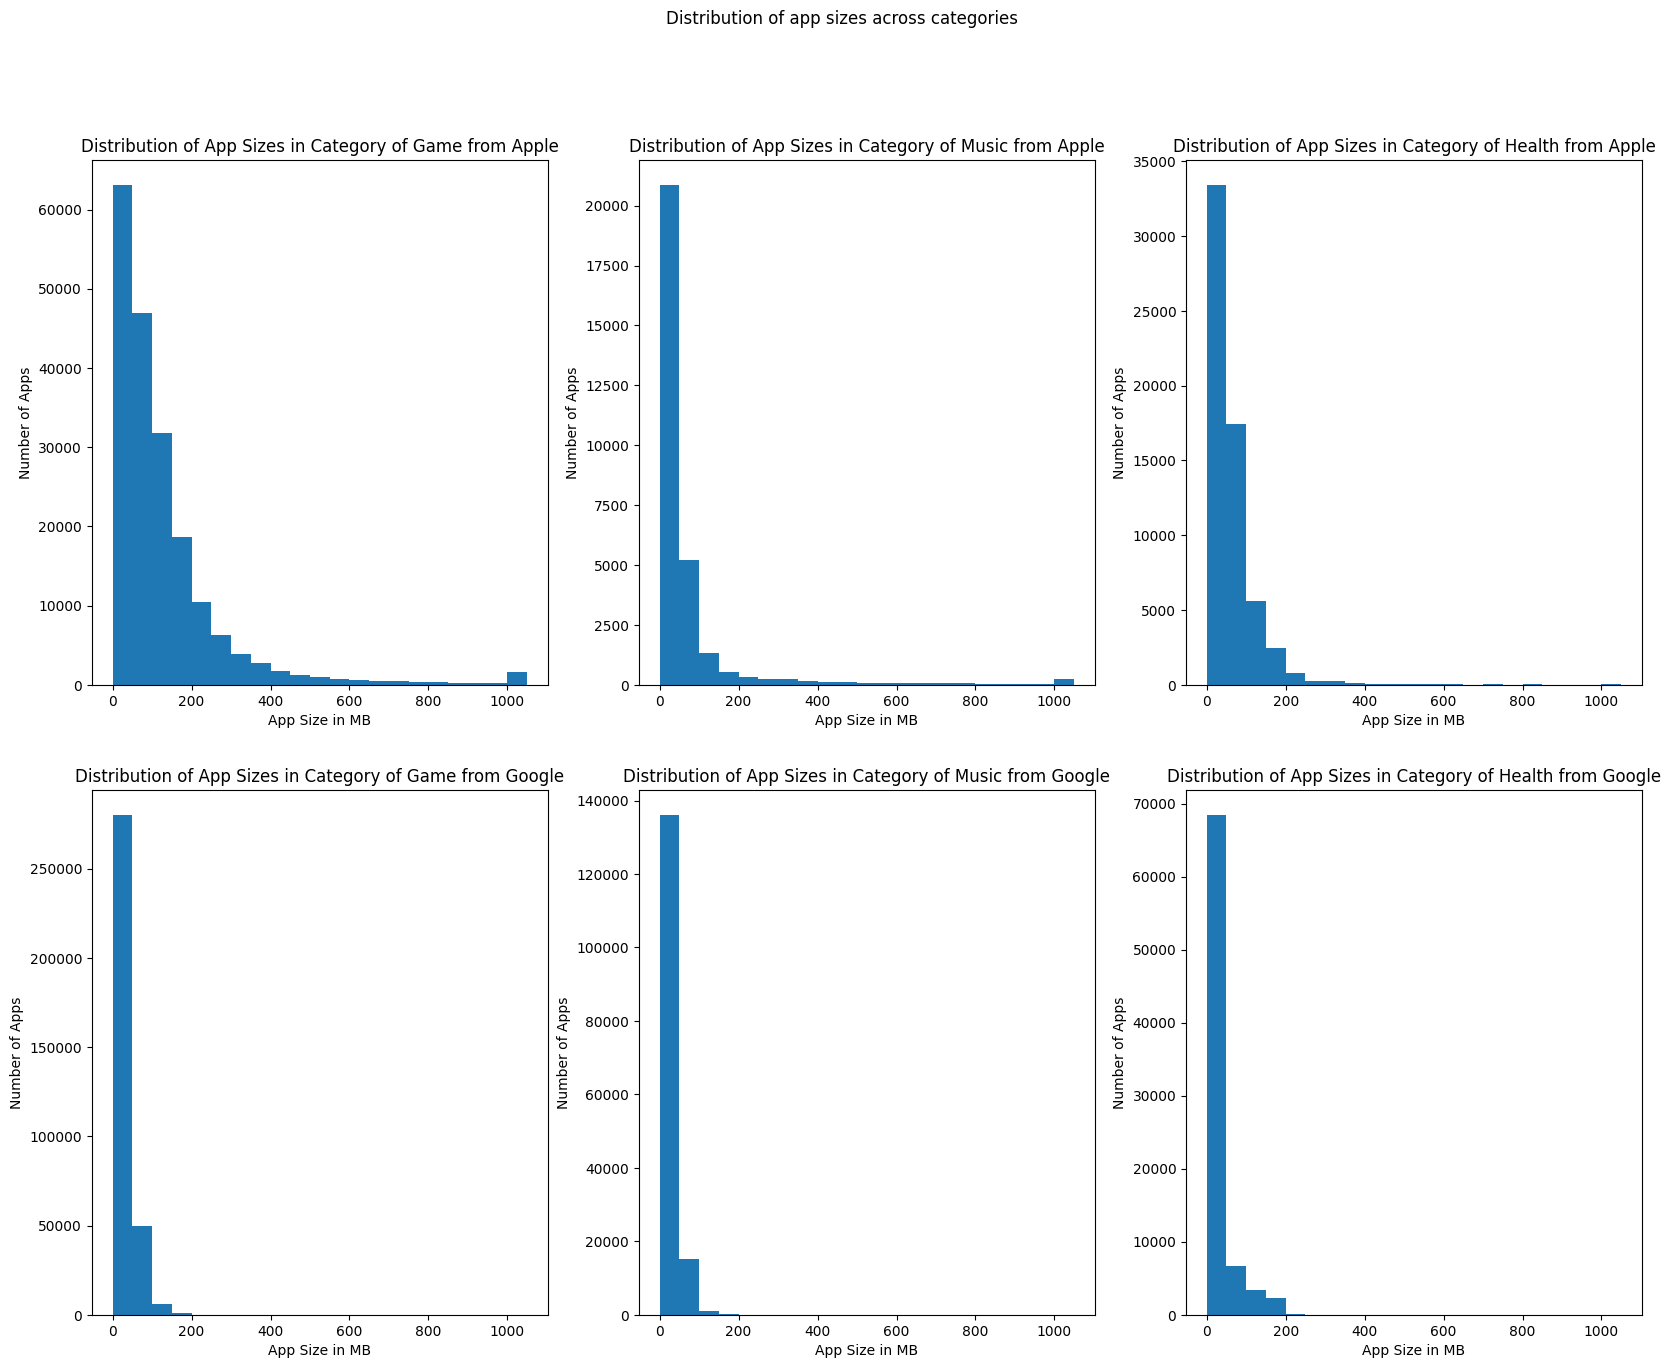

In [9]:
fig,axs=plt.subplots(2,3,figsize=(20,15),sharex=False,sharey=False)
fig.suptitle('Distribution of app sizes across categories')

df_list = [selected_apple_df, selected_google_df]
source_list = ["Apple", "Google"]
category_list = ["Game", "Music", "Health"]
category_columns = ["Primary_Genre", "Category"]
size_columns = ["Size_Bytes", "Size"]
for i in range(2):
  for j in range(3):
    dist_data=df_list[i].filter(col(category_columns[i])==category_list[j]).select(size_columns[i]).rdd.flatMap(lambda _: _).histogram(list(range(0, 1050, 50)) + [3000])
    axs[i][j].bar(dist_data[0][:-1], dist_data[1], width=50, align='edge')
    axs[i][j].set_xlabel('App Size in MB')
    axs[i][j].set_ylabel('Number of Apps')
    axs[i][j].set_title('Distribution of App Sizes in Category of ' + category_list[j] + ' from ' + source_list[i])
plt.show()

For apps from Appstore, we put all apps of size > 1000MB in the same bin. Each bin in the above plot has a bin size of 50MB.

# **Average Rating Across All Ratings for Each Categorie**

In [ ]:
rate_columns = ["Average_User_Rating", "Rating"]
rate_count_columns = ["Reviews", "Rating Count"]
for i in range(2):
  print("Average rating of apps from " + source_list[i])
  df_list[i].withColumn("total_rating", col(rate_columns[i]) * col(rate_count_columns[i])) \
  .groupBy(category_columns[i]) \
  .agg(sum("total_rating").alias("sum_total_rating"),
       sum(rate_count_columns[i]).alias("sum_reviews")) \
  .withColumn("Average_Rating", round(col("sum_total_rating") / col("sum_reviews"), 3)) \
  .select(category_columns[i], "Average_Rating") \
  .show()

Average rating of apps from Apple
+-------------+--------------+
|Primary_Genre|Average_Rating|
+-------------+--------------+
|       Health|         4.754|
|        Music|         4.767|
|         Game|          4.62|
+-------------+--------------+

Average rating of apps from Google
+--------+--------------+
|Category|Average_Rating|
+--------+--------------+
|  Health|         4.475|
|   Music|         4.387|
|    Game|         4.278|
+--------+--------------+



# **Number of New Releases in Each Category by Month**

<Axes: title={'center': 'Number of new releases on Appstore in each category over time by month'}, xlabel='Release_Month'>

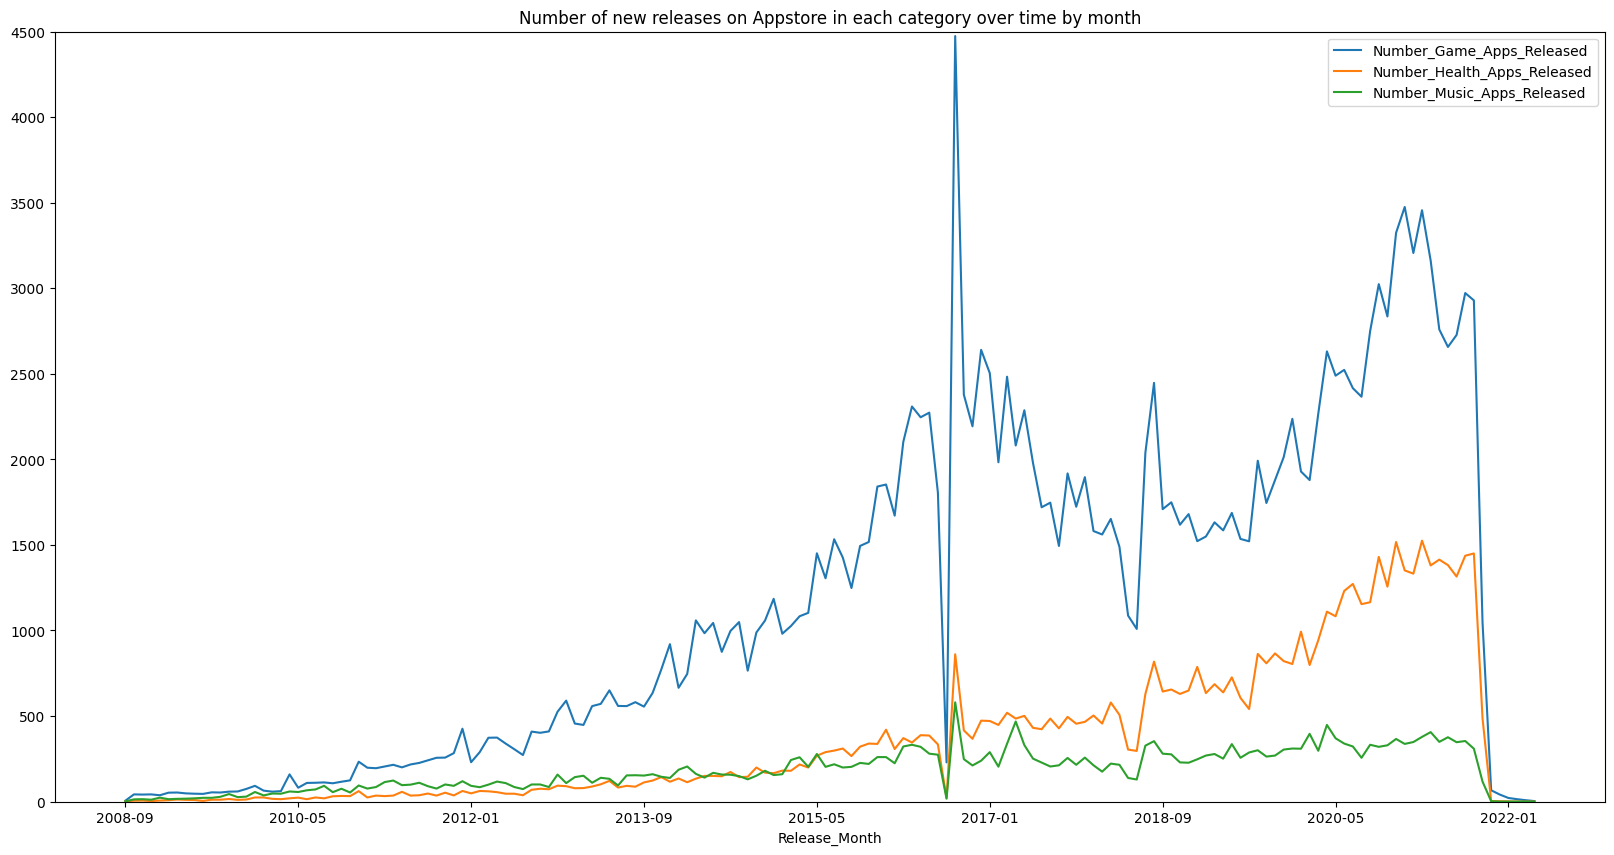

In [ ]:
release_history_apple = selected_apple_df.filter(col("Released").isNotNull()) \
.groupBy("Release_Month") \
.agg(sum(when(col("Primary_Genre")=="Game", 1).otherwise(0)).alias("Number_Game_Apps_Released"),
     sum(when(col("Primary_Genre")=="Health", 1).otherwise(0)).alias("Number_Health_Apps_Released"),
     sum(when(col("Primary_Genre")=="Music", 1).otherwise(0)).alias("Number_Music_Apps_Released")) \
.sort("Release_Month")
apple_pandasDF = release_history_apple.toPandas()
apple_pandasDF.set_index('Release_Month').plot(figsize=(20, 10), ylim=(0, 4500), title='Number of new releases on Appstore in each category over time by month')

Abnormality is observed around Aug. 2016 and Jul. 2018. Seems like many apps planned to be released in Aug. 2016 were postponed to be relased in Sep. 2016. The database has sparse coverage after Dec. 2021.

<Axes: title={'center': 'Number of new releases on Google Play in each category over time by month'}, xlabel='Release_Month'>

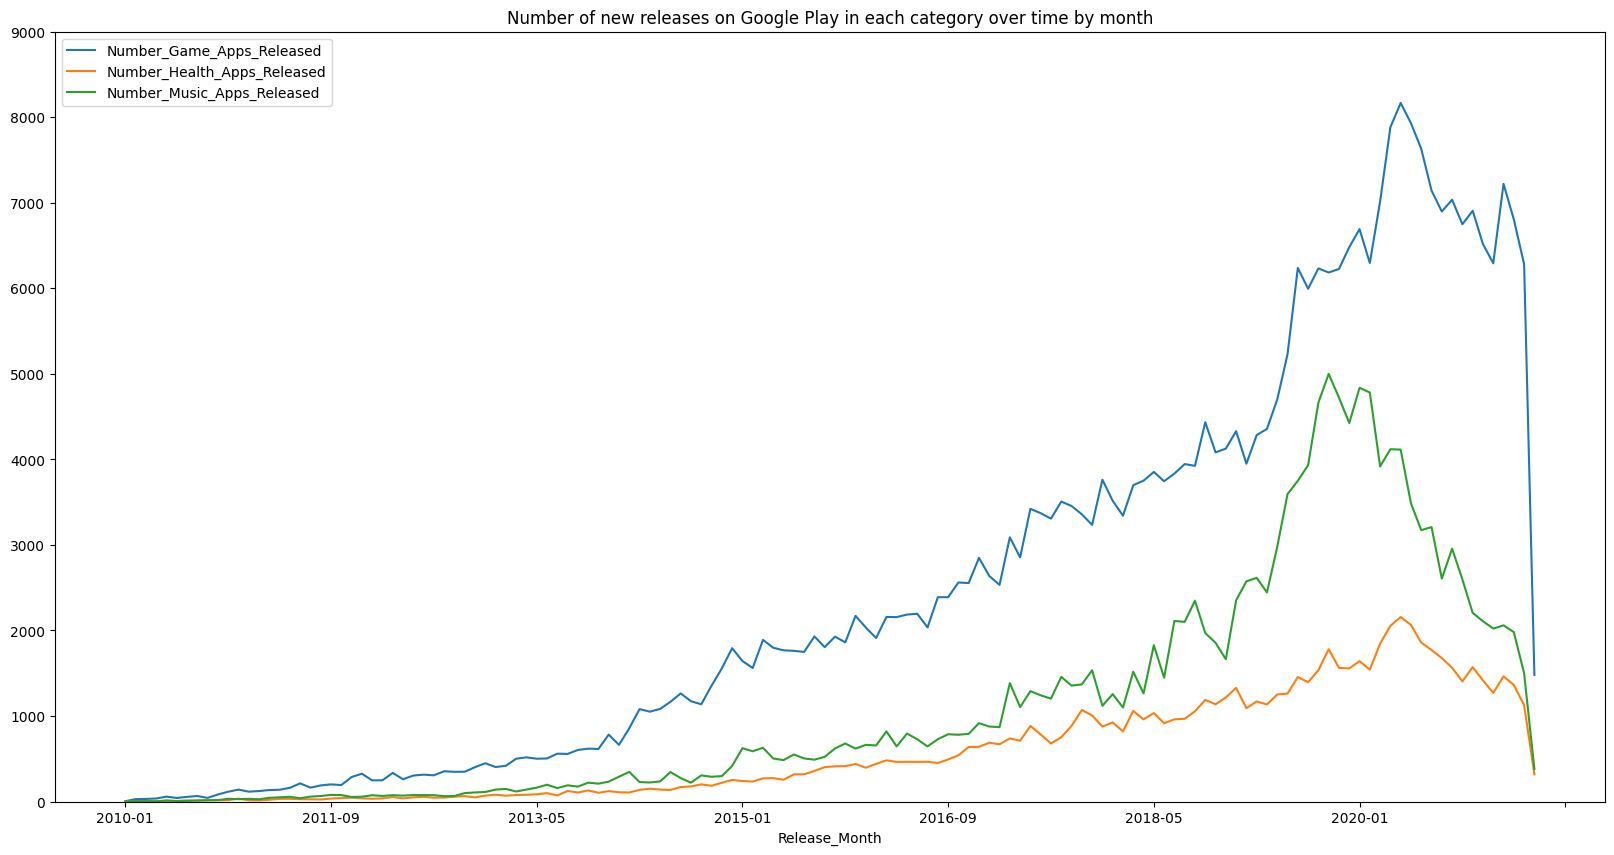

In [ ]:
google_release_history = selected_google_df.filter(col("Release_Month").isNotNull()) \
.groupBy("Release_Month") \
.agg(sum(when(col("Category")=="Game", 1).otherwise(0)).alias("Number_Game_Apps_Released"),
     sum(when(col("Category")=="Health", 1).otherwise(0)).alias("Number_Health_Apps_Released"),
     sum(when(col("Category")=="Music", 1).otherwise(0)).alias("Number_Music_Apps_Released")) \
.sort("Release_Month")
google_pandasDF = google_release_history.toPandas()
google_pandasDF.set_index('Release_Month').plot(figsize=(20, 10), ylim=(0, 9000), title='Number of new releases on Google Play in each category over time by month')

The database has sparse coverage after Dec. 2021.

# **Biggest Apps by Size in Each Category by Year**

In [10]:
apple_windowDept = Window.partitionBy(["Primary_Genre", "Release_Year"]).orderBy(col("Size_Bytes").desc())
apple_row_df=selected_apple_df.withColumn("row",row_number().over(apple_windowDept)) \
.filter(col("row") <= 10) \
.select("App_Name", "Primary_Genre", "Release_Year", round("Size_Bytes", 2).alias("Size_MB")) \
.cache()

In [11]:
for i in range(2008, 2023, 1):
  for category in category_list:
    print("In Appstore, the 10 biggest apps by size in category " + category + " by year " + str(i) + " are:")
    apple_row_df.filter((col("Primary_Genre") == category) & (col("Release_Year") == i)) \
    .select("App_Name", "Size_MB") \
    .show(truncate = False)

In Appstore, the 10 biggest apps by size in category Game by year 2008 are:
+-----------------------------------------------------------------+-------+
|App_Name                                                         |Size_MB|
+-----------------------------------------------------------------+-------+
|QBeez                                                            |253.42 |
|PAC-MAN                                                          |210.49 |
|Kroll                                                            |200.91 |
|Solitaire Classic ©                                              |172.08 |
|Soccer Physics - free online foosball skill free addicting games!|150.09 |
|Checkers ・                                                      |118.77 |
|Backgammon - Classic Dice Game                                   |114.96 |
|Crazy Snowboard                                                  |98.87  |
|Deep Green Chess                                                 |94.56  |
|Iron Fist Bo

In [12]:
google_windowDept = Window.partitionBy(["Category", "Release_Year"]).orderBy(col("Size").desc())
google_row_df=selected_google_df.filter(col("Release_Year").isNotNull()) \
.withColumn("row",row_number().over(google_windowDept)) \
.filter(col("row") <= 10) \
.select("App Name", "Category", "Release_Year", col("Size").alias("Size_MB")) \
.cache()

In [13]:
for i in range(2010, 2022, 1):
  for category in category_list:
    print("In Google Play, the 10 biggest apps by size in category " + category + " by year " + str(i) + " are:")
    google_row_df.filter((col("Category") == category) & (col("Release_Year") == i)) \
    .select("App Name", "Size_MB") \
    .show(truncate = False)

In Google Play, the 10 biggest apps by size in category Game by year 2010 are:
+--------------------------------------------------+-------+
|App Name                                          |Size_MB|
+--------------------------------------------------+-------+
|Yahoo Fantasy Sports: Football, Baseball & More   |330.0  |
|Tour Tempo Golf - Total Game                      |112.0  |
|Angry Birds Seasons                               |100.0  |
|Angry Birds Classic                               |99.0   |
|GolfLogix GPS + Putt Line                         |97.0   |
|Zynga Poker ™: Free Texas Holdem Online Card Games|97.0   |
|Atlanta Falcons Mobile                            |93.0   |
|BattleBears Zombies                               |92.0   |
|FC Red Bull Salzburg App                          |91.0   |
|TUDN: Univision Deportes Network                  |86.0   |
+--------------------------------------------------+-------+

In Google Play, the 10 biggest apps by size in category Music by y